# Gaussian Processes

(Chapter 15)

for $y_i = f(\mathbf x_i)$, for some unknown function $f$, the optimal approach is to infer a *distributions over functions* given the data $p(f|\mathbf X, \mathbf y)$, and use this to make predictions given new inputs.


\begin{align*}
p(y_*| x_*, \mathbf X, \mathbf y) = \int p(y_* | f, \mathbf x_*) p(f | \mathbf X, \mathbf y) df
\end{align*}

where we integrate over the entire space of functions ...


The assumption is that given a set of points $\mathbf x_1, \mathbf x_2, \ldots, \mathbf x_N$, the $\mathcal {GP}$ assumes that the joint distribution $p(f(\mathbf x_1), f(\mathbf x_2), \ldots, f(\mathbf x_N))$ is jointly Gaussian with some mean $\mathbf \mu(\mathbf x)$ and covariance $\mathbf \Sigma(x)$ given by $\Sigma_{ij}=\kappa(\mathbf x_i, \mathbf x_j)$


\begin{align*}
f(\mathbf x) \sim \mathcal {GP} ( m(\mathbf x), \kappa(\mathbf x, \mathbf x') )
\end{align*}


Here,


\begin{align*}
m(\mathbf x) &= \mathbf E [f(\mathbf x)] \\
\kappa(\mathbf x, \mathbf x') &= \mathbf E[(f(\mathbf x) - m(\mathbf x))(f(\mathbf x') - m(\mathbf x'))^{\top}]
\end{align*}


Training Data $\mathcal D = \{(\mathbf x_i, f_i), i = 1:N\}$, is noise free. Given a test set $\mathbf X_*$ of size $(N_* \times D)$, we want to predict outputs $\mathbf f_*$

By definition, the calculation for the $\mathcal {GP}$ is ...

$$
\begin{align*}
\left( \begin{array}{c}
    \mathbf f \\
    \mathbf f_*
    \end{array} \right) 
    \sim  
\mathcal N 
\left( \left( \begin{array}{c}
\mathbf \mu \\
\mathbf \mu_*
\end{array} \right), 
\left( \begin{array}{c}
\mathbf K   & \mathbf K_* \\
\mathbf K_*^{\top} & \mathbf K_{**}
\end{array} \right) \right)
\end{align*}
$$

The posterior has the following form:

\begin{align*}
p(\mathbf f_* | \mathbf X_*, \mathbf X, \mathbf f) &= \mathcal N \left( \mathbf f_* | \mathbf \mu_*, \mathbf \Sigma_*  \right) \\
                                     \mathbf \mu_* &= \mathbf \mu( \mathbf X_* ) + \mathbf K_*^{\top}\mathbf K_*^{-1}( \mathbf f - \mathbf \mu( \mathbf X ) ) \\
                                  \mathbf \Sigma_* &= \mathbf K_{**} - \mathbf K_*^{\top}\mathbf K^{-1}\mathbf K_*
\end{align*}

Reference:

 - http://krasserm.github.io/
 - https://blog.dominodatalab.com/fitting-gaussian-process-models-python/
 - https://stackoverflow.com/questions/35166684/implementation-of-gaussian-process-regression-in-python-yn-samples-n-targets
 - http://krasserm.github.io/2018/03/19/gaussian-processes/

In [2]:
cd ../src

/home/sankha/Documents/programs/ML/densityNN/src


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%config InlineBackend.figure_format='retina'

In [37]:
D = 2
w = [0.3, -0.1, 0.05, -0.0045, 0.000076]

# Samples ...
N = 5
t = np.random.rand(N)*10
X = np.array([ np.random.rand(N)*10 for i in range(D) ]).T
y = X @ w[:D]

In [38]:
# Using the Gaussian Kernel here ..
l = 1
sigma = 0.1
K = np.array([ sigma**2*np.exp( -(0.5/l**2)*((X - x)**2).sum(axis=1)) for x in X ])

In [42]:
# Evaluation ...
NEval = 10
temp = [m+np.random.rand(10, 2)*5 for m in X]
temp+= [m+np.random.rand(10, 2)*1 for m in X]
temp+= [m+np.random.rand(10, 2)*0.5 for m in X]
XNew = np.vstack(temp)
KNew = np.array([ sigma**2*np.exp( -(0.5/l**2)*((XNew - x)**2).sum(axis=1)) for x in XNew ])

KOldNew  = np.array([ sigma**2*np.exp( -(0.5/l**2)*((XNew - x)**2).sum(axis=1)) for x in X ])
muNew    = KOldNew.T @ np.linalg.inv(K) @ y.reshape(-1, 1)
SigmaNew = KNew - KOldNew.T @ np.linalg.inv(K) @ KOldNew

In [43]:
yTest = np.random.multivariate_normal(muNew.flatten(), SigmaNew, 24)

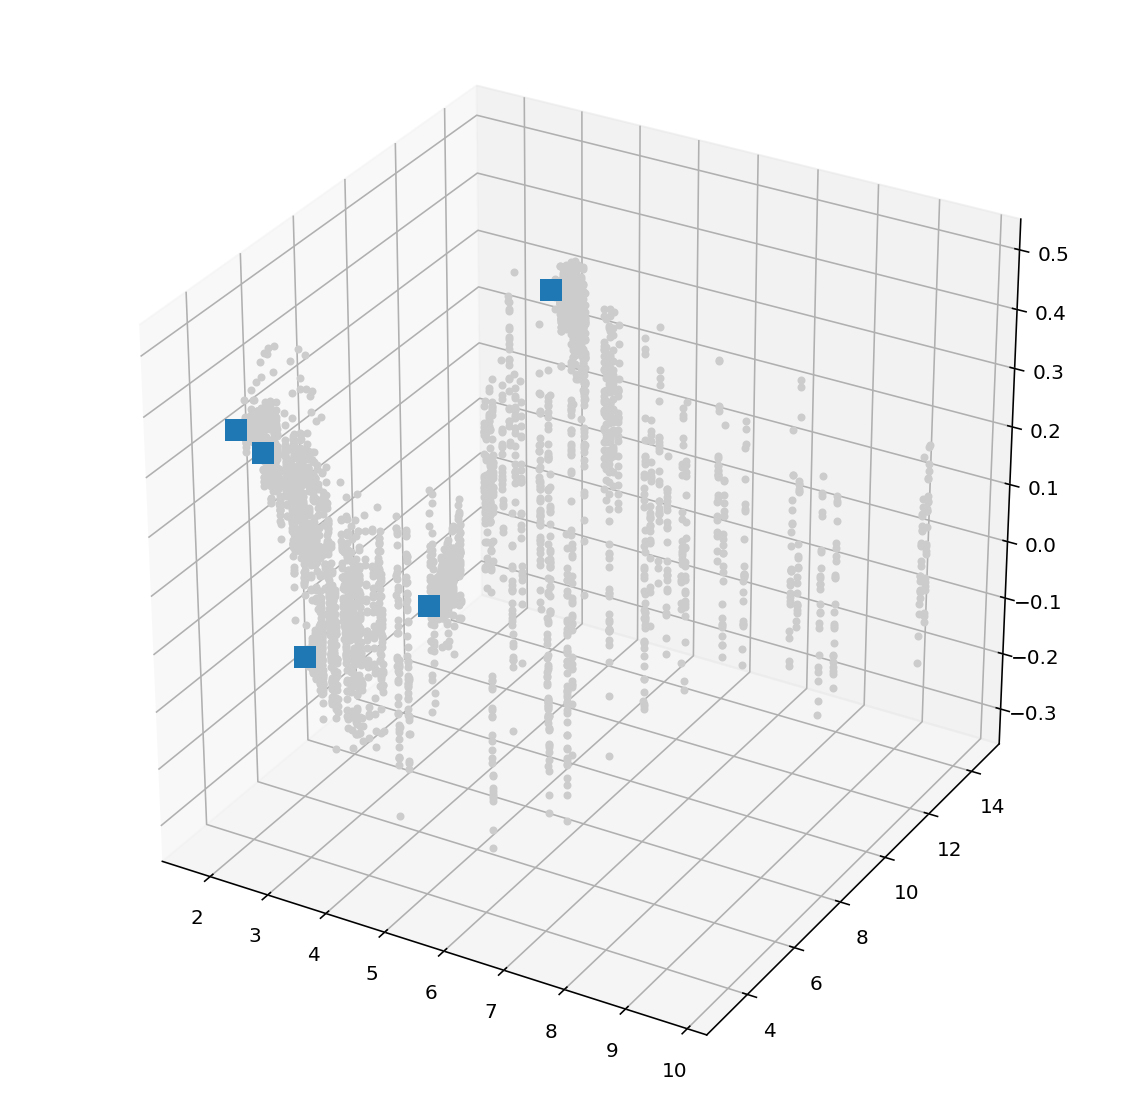

In [46]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for y1 in yTest:
    ax.plot(XNew[:,0], XNew[:,1], y1, '.', c=(0.8, 0.8, 0.8))
    
ax.plot(X[:,0], X[:,1], y, 's', ms=10)

plt.show()
plt.close('all')

In [83]:
class GP_Normal:
    
    def __init__(self, X, y, sigmaN=0):
        
        self.X = X
        self.y = y
        self.K = self.kernel_Gauss( X, X )
        if sigmaN != 0:
            self.K += np.eye( X.shape[0] ) * sigmaN
        
        return
    
    def kernel_Gauss(self, X1, X2, l=1, sigma=1):
        
        if X1.shape[0] < X2.shape[0]:
            K = np.array([ sigma**2*np.exp( -(0.5/l**2)*((X2 - x)**2).sum(axis=1)) for x in X1 ])
        else:
            K = np.array([ sigma**2*np.exp( -(0.5/l**2)*((X1 - x)**2).sum(axis=1)) for x in X2 ])
            K = K.T
        
        return K
    
    def sampleX(self, XNew, NSamples=1):
        
        KNew    = self.kernel_Gauss(XNew, XNew)
        KOldNew = self.kernel_Gauss(self.X, XNew)
        
        muNew    = KOldNew.T @ np.linalg.inv(self.K) @ self.y.reshape(-1, 1)
        SigmaNew = KNew - KOldNew.T @ np.linalg.inv(self.K) @ KOldNew
        
        yNew = np.random.multivariate_normal(muNew.flatten(), SigmaNew, NSamples)
        
        return yNew
    
    

In [94]:
D = 1

XAll = np.linspace(0, 10, 1000).reshape(-1, 1)
yAll = 2*np.exp( -(XAll -3)**2/(3) ) + 5*np.exp( -(XAll -7)**2/(1) )

# Samples ...
N = 5
X = np.array([ np.random.rand(N)*10 for i in range(D) ]).T
y = 2*np.exp( -(X -3)**2/(3) ) + 5*np.exp( -(X -7)**2/(1) )

In [95]:
XNew = np.linspace(0, 10, 100).reshape(-1, 1)

In [96]:
gp = GP_Normal(X, y, 0.01)
yNews = gp.sampleX(XNew, 100)

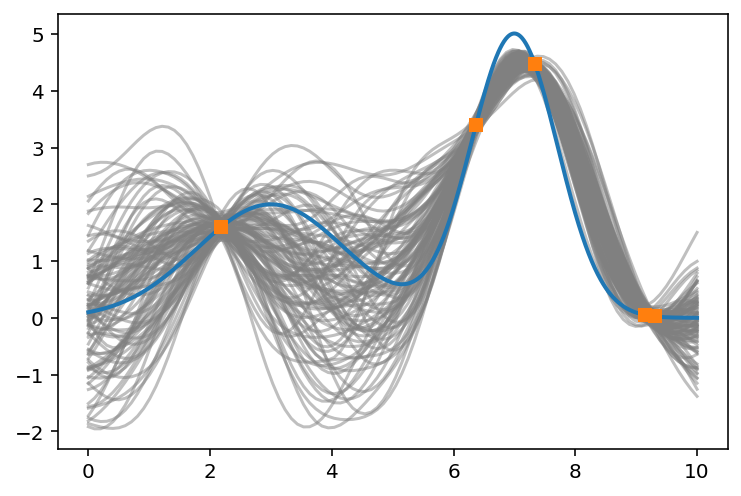

In [97]:
for yN in yNews:
    plt.plot(XNew[:, 0], yN, color=(0.5, 0.5, 0.5), alpha=0.5)

plt.plot(XAll[:, 0], yAll[:, 0], lw=2)
plt.plot(X[:, 0], y[:, 0], 's')
plt.show()
plt.close('all')